In [134]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [135]:
RESULTS_DIR = "./outputs/results"
!ls {RESULTS_DIR}

junctions_per_class.csv    wall_junctions_mixed.csv
segmentation_by_class.csv  wall_junctions_no_class.csv
segmentation_global.csv    wall_junctions_per_class.csv


This notebook concerns the evaluation of the model's results.

In [136]:
def color(data, cmap="Greens"):
    return data.style.background_gradient(cmap=cmap, low=0, high=1.0, axis=0)

## Global segmentation results

In [137]:
global_seg_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_global.csv")
color(global_seg_results)

,name,Overall Acc,Mean Acc,FreqW Acc,Mean IoU
0,Room segmentation,0.825413,0.695570,0.716768,0.572802
1,Room polygon segmentation,0.773188,0.617211,0.636310,0.494661
2,Icon segmentation,0.975057,0.602279,0.953139,0.549512
3,Icon polygon segmentation,0.966732,0.461216,0.937448,0.423070


### Class segmentation results

In [144]:
color(class_seg_results_dict["Room segmentation"])

,name,class_names,Class IoU,Class Acc
0,Room segmentation,Background,87.220000,93.700000
1,Room segmentation,Outdoor,64.180000,77.760000
2,Room segmentation,Wall,72.160000,83.300000
3,Room segmentation,Kitchen,64.870000,79.980000
4,Room segmentation,Living Room,66.440000,82.700000
5,Room segmentation,Bedroom,73.970000,86.340000
6,Room segmentation,Bath,60.440000,73.620000
7,Room segmentation,Hallway,55.460000,71.360000
8,Room segmentation,Railing,22.920000,27.440000
9,Room segmentation,Storage,44.740000,54.010000


In [145]:
color(class_seg_results_dict["Room polygon segmentation"])

,name,class_names,Class IoU,Class Acc
12,Room polygon segmentation,Background,79.090000,92.910000
13,Room polygon segmentation,Outdoor,48.220000,60.540000
14,Room polygon segmentation,Wall,49.820000,54.960000
15,Room polygon segmentation,Kitchen,58.300000,73.980000
16,Room polygon segmentation,Living Room,62.200000,81.320000
17,Room polygon segmentation,Bedroom,68.800000,83.610000
18,Room polygon segmentation,Bath,56.710000,69.920000
19,Room polygon segmentation,Hallway,53.700000,68.450000
20,Room polygon segmentation,Railing,6.400000,6.760000
21,Room polygon segmentation,Storage,40.490000,48.930000


In [146]:
color(class_seg_results_dict["Icon segmentation"])

,name,class_names,Class IoU,Class Acc
24,Icon segmentation,Empty,97.500000,99.370000
25,Icon segmentation,Window,65.400000,71.350000
26,Icon segmentation,Door,51.980000,57.020000
27,Icon segmentation,Closet,68.390000,76.170000
28,Icon segmentation,Electr. Appl.,65.190000,74.020000
29,Icon segmentation,Toilet,61.490000,66.380000
30,Icon segmentation,Sink,54.720000,64.300000
31,Icon segmentation,Sauna bench,67.040000,73.420000
32,Icon segmentation,Fire Place,35.630000,39.680000
33,Icon segmentation,Bathtub,26.340000,29.570000


In [147]:
color(class_seg_results_dict["Icon polygon segmentation"])

,name,class_names,Class IoU,Class Acc
35,Icon polygon segmentation,Empty,96.630000,99.400000
36,Icon polygon segmentation,Window,42.150000,46.190000
37,Icon polygon segmentation,Door,43.310000,49.960000
38,Icon polygon segmentation,Closet,64.160000,70.230000
39,Icon polygon segmentation,Electr. Appl.,60.650000,68.720000
40,Icon polygon segmentation,Toilet,57.240000,62.130000
41,Icon polygon segmentation,Sink,46.260000,53.960000
42,Icon polygon segmentation,Sauna bench,48.810000,50.560000
43,Icon polygon segmentation,Fire Place,3.170000,3.190000
44,Icon polygon segmentation,Bathtub,0.000000,0.000000


In [138]:
class_seg_results = pd.read_csv(f"{RESULTS_DIR}/segmentation_by_class.csv")
room_mask = class_seg_results.name.isin(["Room segmentation", "Room polygon segmentation"])
room_seg_results, icon_seg_results = class_seg_results[room_mask], class_seg_results[~room_mask]

<AxesSubplot:title={'center':'Room Class Acc discriminated by class'}, xlabel='Class Acc', ylabel='class_names'>

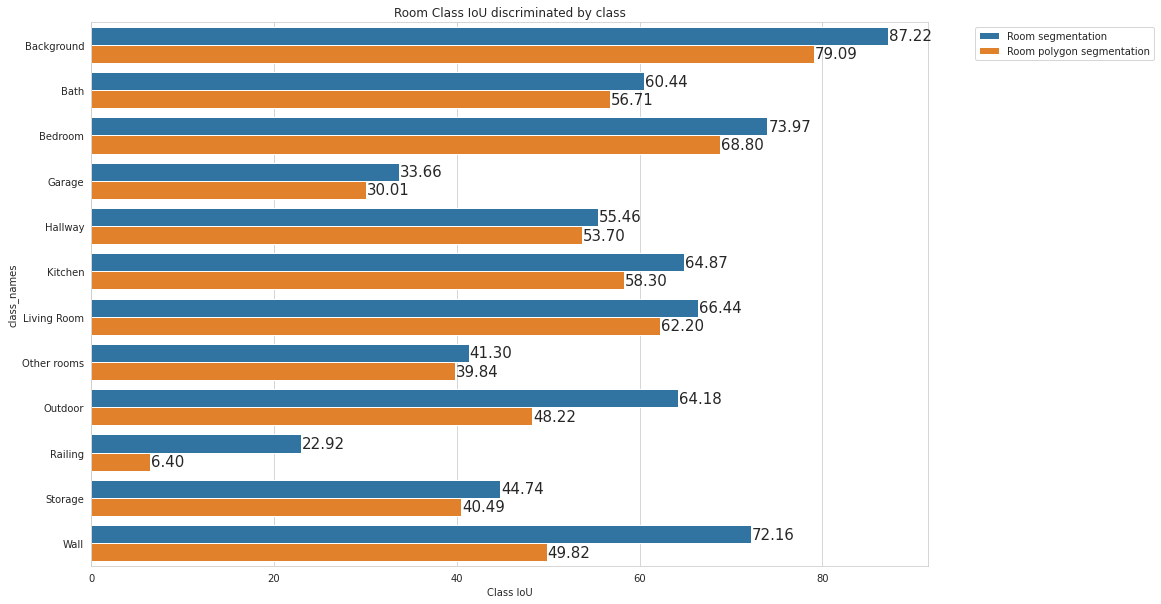

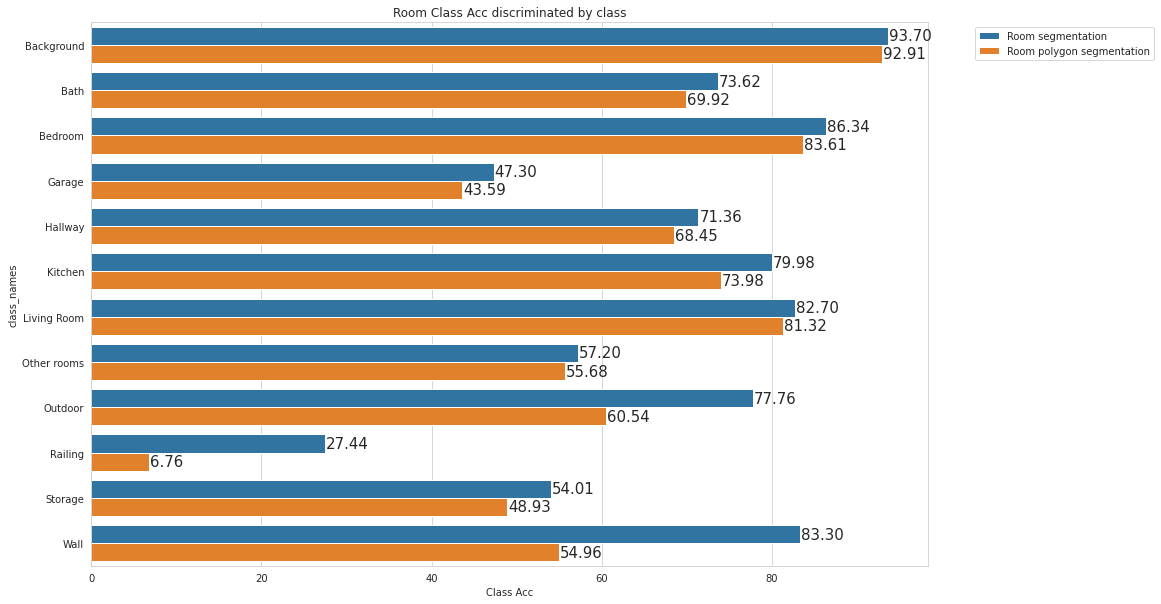

In [142]:
def plot_segmentation_results(data, metric, figsize=(15, 10)):
    data = data.sort_values("class_names")
    plt.figure(figsize=figsize)
    plt.title(f"Room {metric} discriminated by class")
    plt.ylabel("Class names")
    
    splot = sns.barplot(data=data, x=metric, y="class_names", hue="name", orient="h")

    for p in splot.patches:

        splot.annotate(
            format(p.get_width(), '.2f'), 
            xy=(p.get_width(), p.get_y()+p.get_height()/2),
            ha = 'left',
            va = 'center', 
            size=15, 
            xytext = (1, 0),
            textcoords = 'offset points')
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    return splot
        
    
plot_segmentation_results(data=room_seg_results, metric="Class IoU")
plot_segmentation_results(data=room_seg_results, metric="Class Acc")

### Icon segmentation results

<AxesSubplot:title={'center':'Room Class Acc discriminated by class'}, xlabel='Class Acc', ylabel='class_names'>

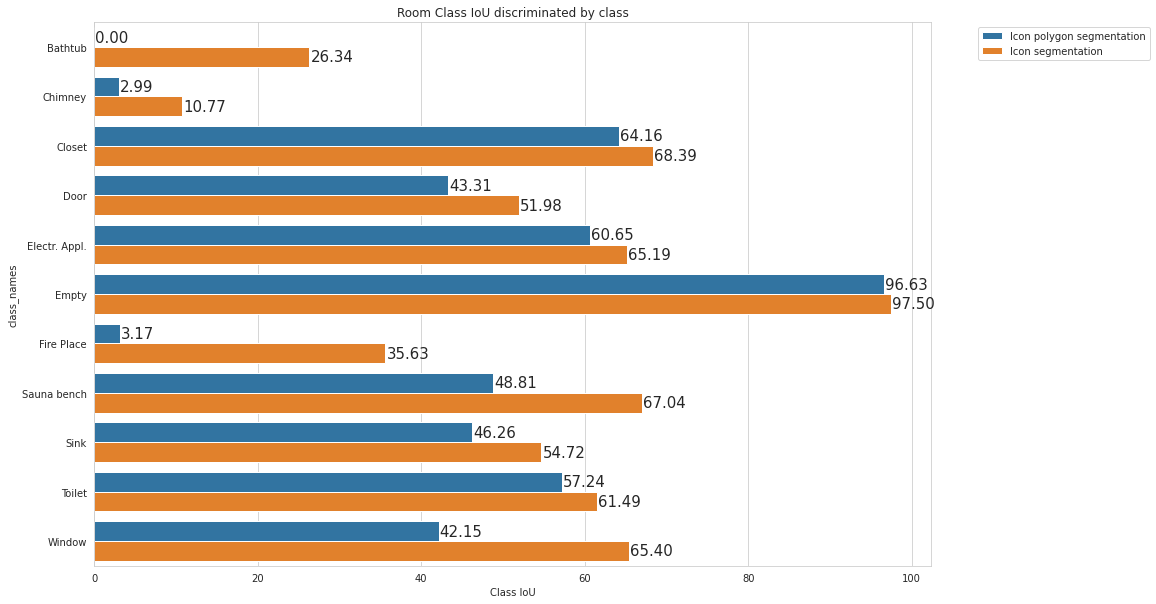

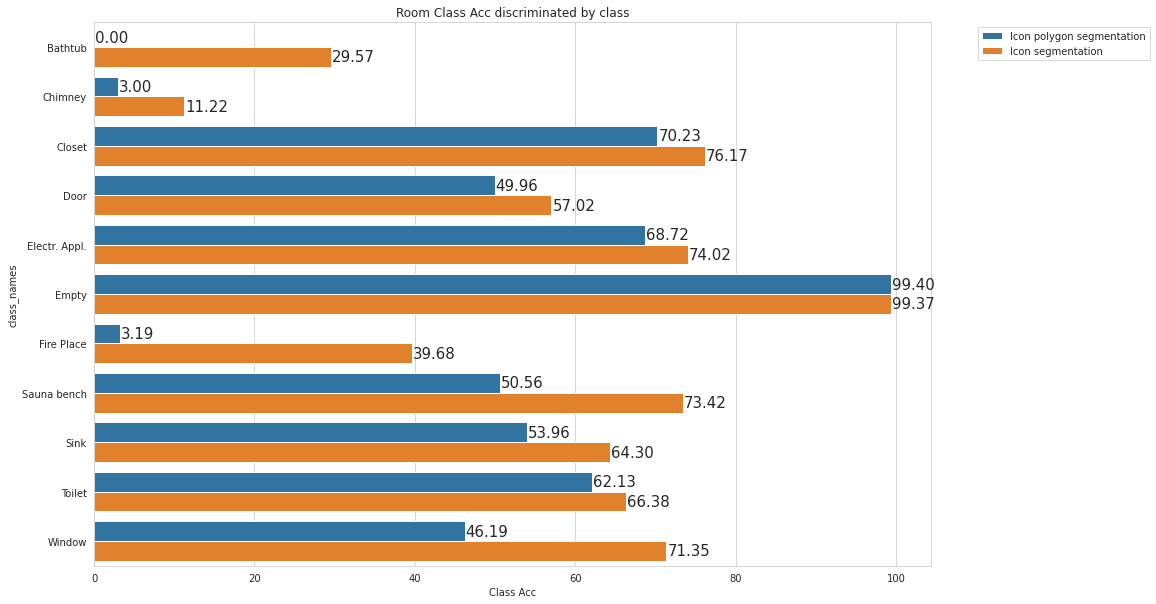

In [143]:
plot_segmentation_results(data=icon_seg_results, metric="Class IoU")
plot_segmentation_results(data=icon_seg_results, metric="Class Acc")

## Junctions per class

In [165]:
def plot_per_class(
    data: pd.DataFrame,
    by: str,
    x: str,
    y: str,
    n_cols: int=3,
    figsize=(15, 15),
    dpi=150,
    **kwargs
):
    n_plots = data[by].nunique()

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=figsize, dpi=dpi)

    for k, by_category in enumerate(data[by].unique()):
        d = data[(data[by] == by_category)]
        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x=x, y=y, ax=ax, **kwargs)
        ax.set_title(f"({by}={by_category}) {y}-{x} curve")

    plt.tight_layout()

In [166]:
junctions = pd.read_csv(f"{RESULTS_DIR}/junctions_per_class.csv", index_col=0)
overall_mask = junctions["class"] == "overall"

junctions_overall = junctions[overall_mask]
junctions_by_class = junctions[~overall_mask]

Text(0.5, 1.0, 'Precision-Recall curve for Junctions *overall*')

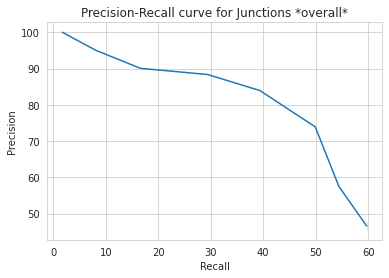

In [171]:
sns.lineplot(data=junctions_overall, x="Recall", y="Precision")
plt.title("Precision-Recall curve for Junctions *overall*")

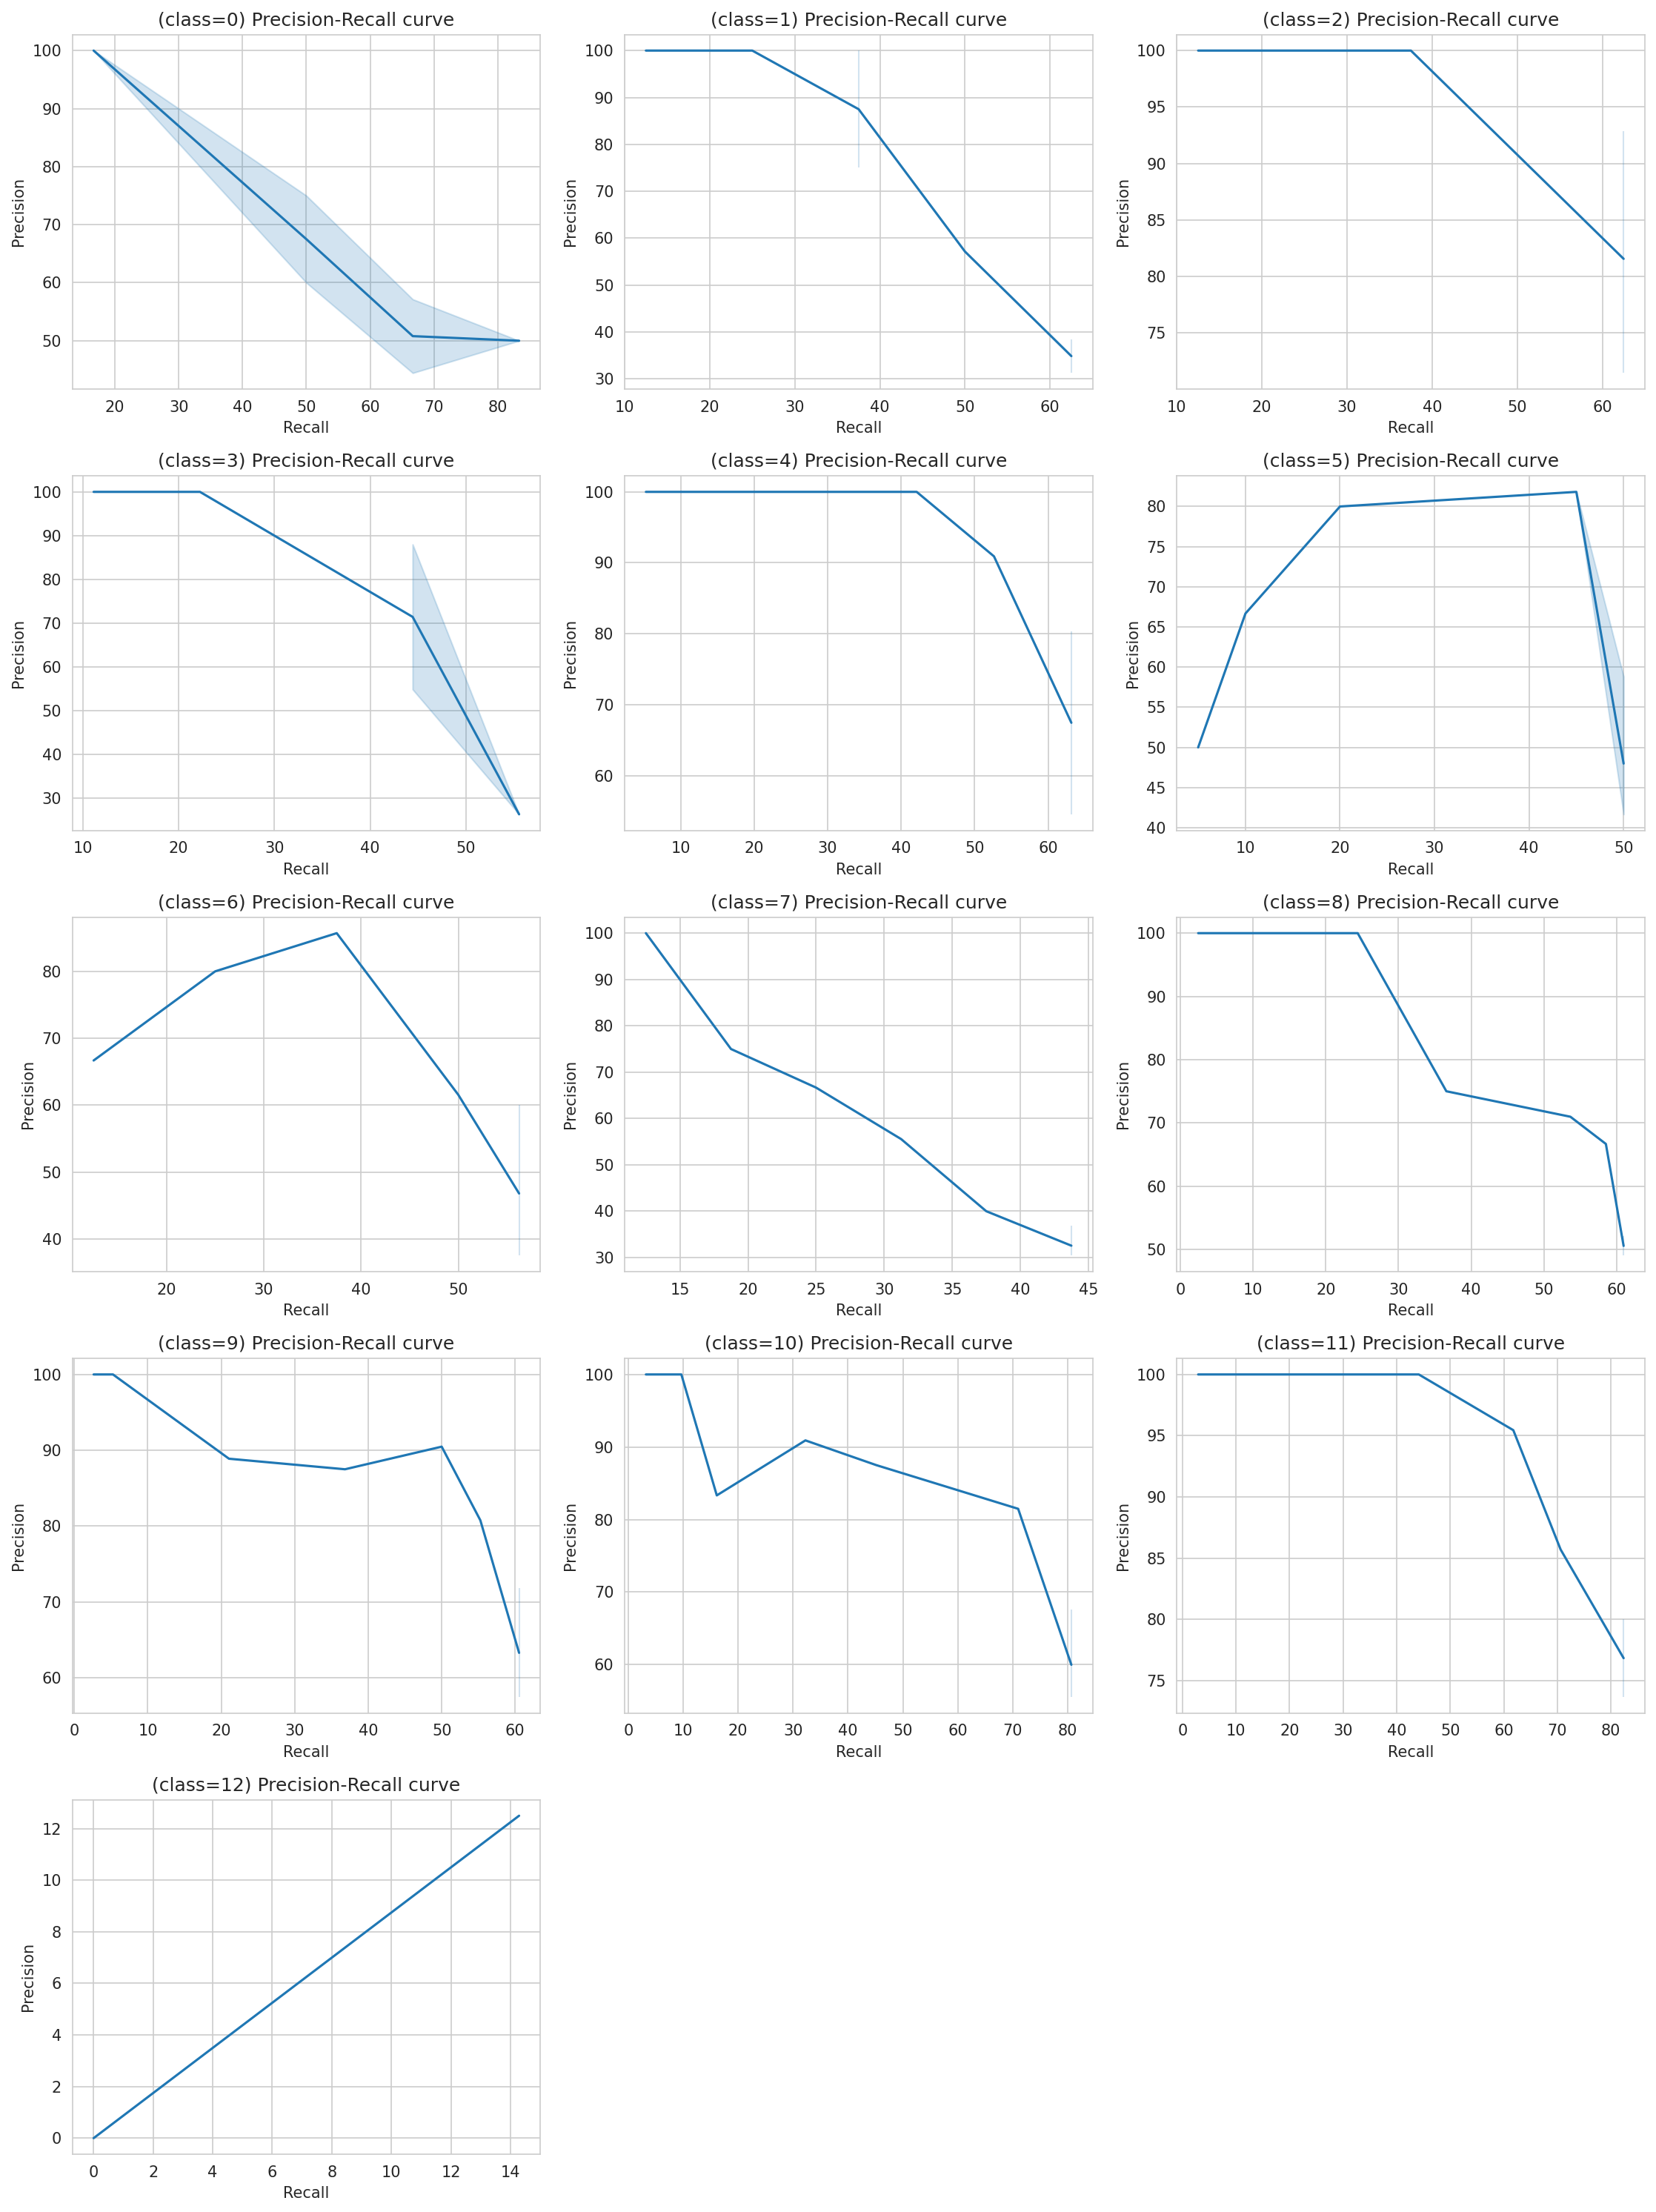

In [172]:
plot_per_class(junctions_by_class, x="Recall", y="Precision", by="class", figsize=(15, 20))

In [185]:
junctions_by_class.head(11)

,threshold,class,Recall,Precision
1,0,0,83.33,50.00
2,0,1,62.50,31.25
3,0,2,62.50,71.43
4,0,3,55.56,26.32
5,0,4,63.16,54.55
6,0,5,50.00,41.67
7,0,6,56.25,37.50
8,0,7,43.75,30.43
9,0,8,60.98,49.02
10,0,9,60.53,57.50


## Mixed Junctions

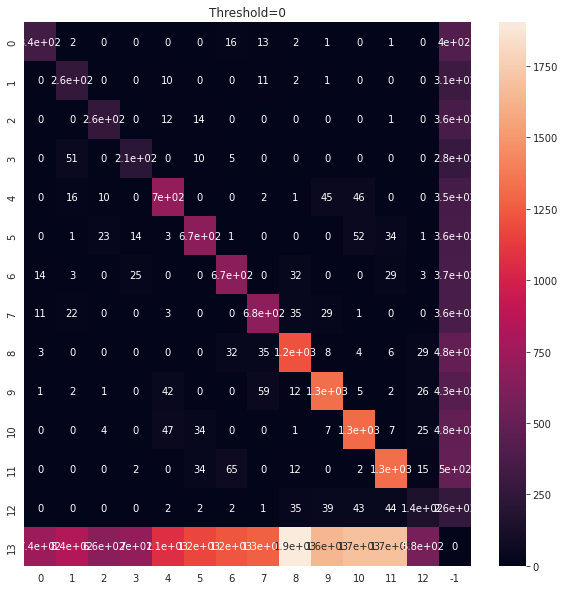

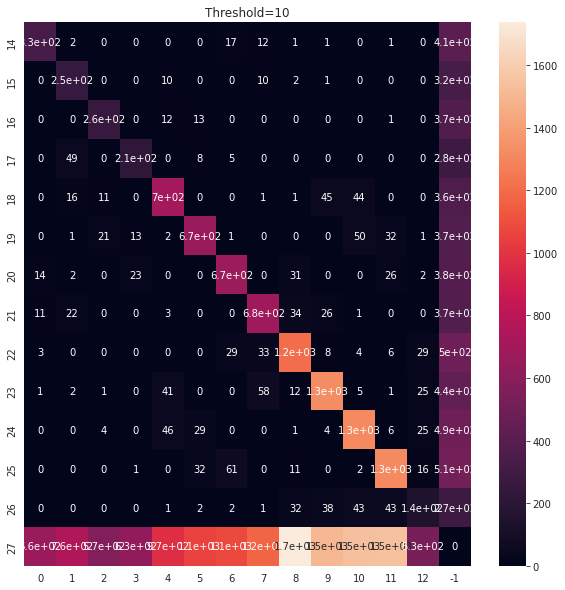

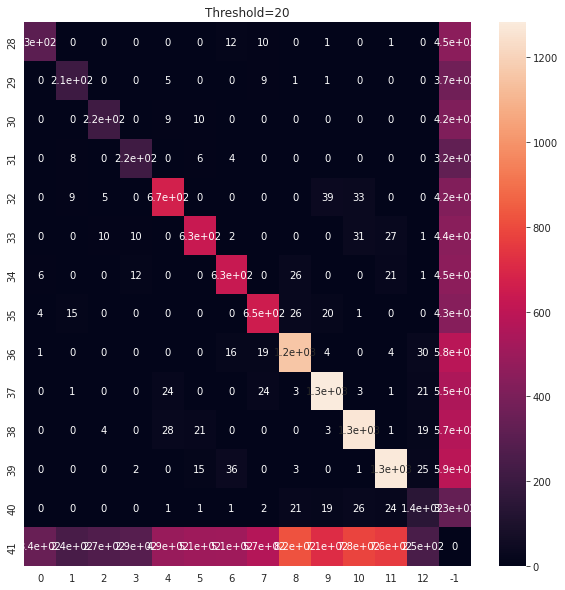

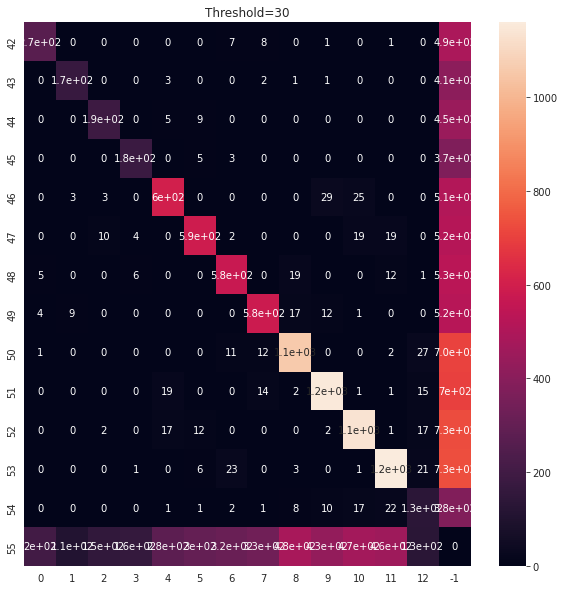

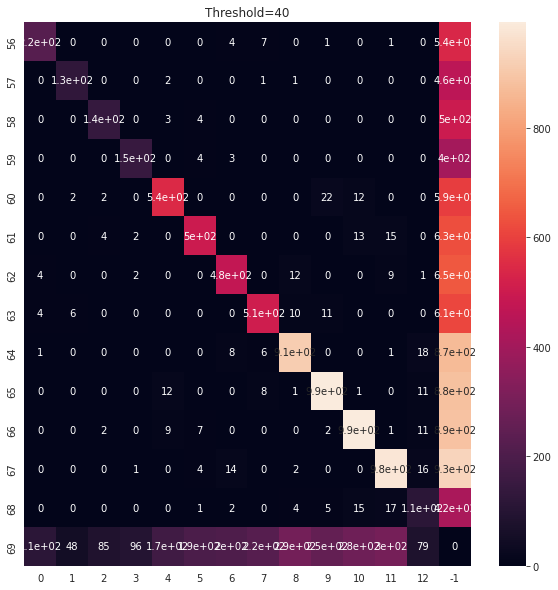

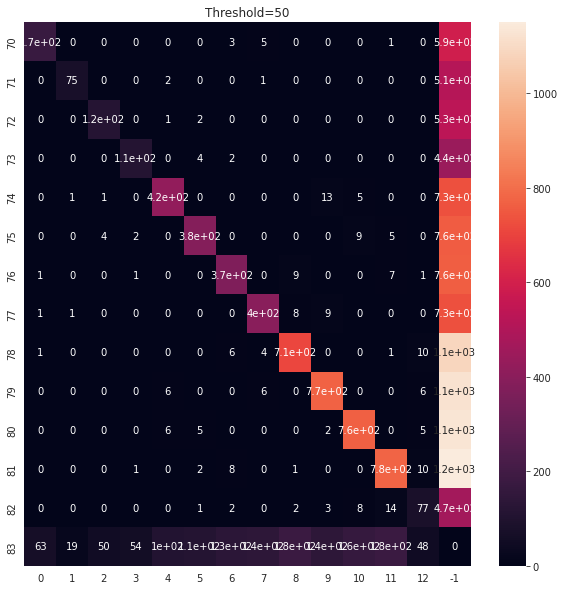

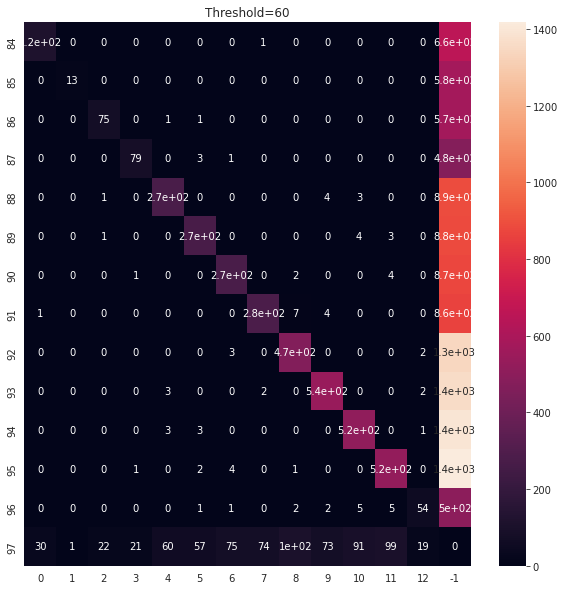

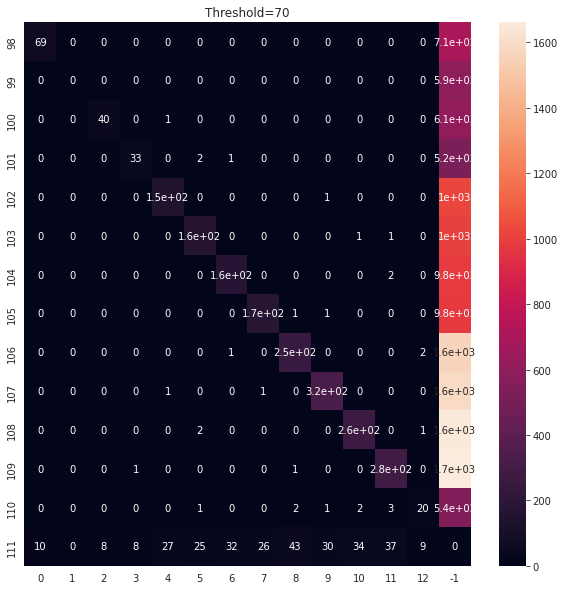

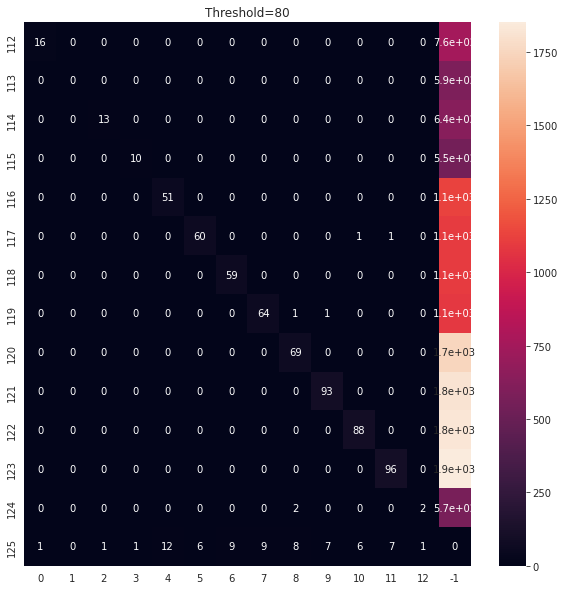

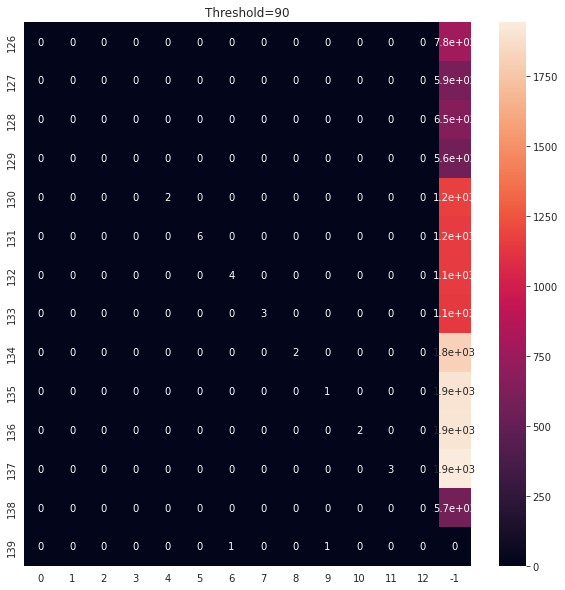

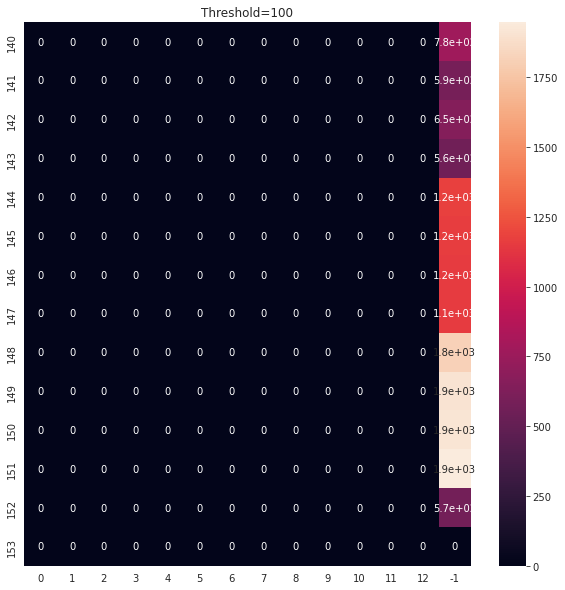

In [183]:
mixed_junctions = pd.read_csv(f"{RESULTS_DIR}/wall_junctions_mixed.csv")

for threshold in mixed_junctions.threshold.unique():
    data = mixed_junctions[mixed_junctions.threshold == threshold].copy()
    data.drop(["class", "threshold"], axis=1, inplace=True)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Threshold={threshold}")
    sns.heatmap(data, vmin=0, annot=True)
    plt.show()

In [ ]:
pd.read_csv(f"{RESULTS_DIR}/wall_junctions_mixed.csv")

In [ ]:
pd.read_csv(f"{RESULTS_DIR}/wall_junctions_mixed.csv")